In [ ]:
integrantes = ("Contreras, Daniel", "Diaz Villa, Virginia", "Hruszecki, Darío", "Marchio, Sergio")

print("TP2 AA, grupo 2 \n")

for i in integrantes:
    print(i)

## Import de librerias utilizadas

In [2]:
import librosa
import glob
import numpy as np
import seaborn as sns
import pandas as pd
import os.path
from os import path

import matplotlib.pyplot as plt

from enum import Enum
from time import time

from IPython.display import Audio
from librosa.display import specshow
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

## Funciones para la obtención de features y modelado

In [3]:
class AudioType(Enum):
  TRAIN= 1   
  VALIDATION= 2   
  TEST= 3   
  CUSTOM= 4   

In [4]:
class Feature:
  def __init__(self, filename, audio_type, noise_type=None):
    self.filename = filename
    self.noise_type = noise_type
    self.audio_type = audio_type

In [26]:
class Features(Enum):
    Train = Feature("train_features.csv",AudioType.TRAIN)
    Validation = Feature("valid_features.csv", AudioType.VALIDATION)
    Test = Feature("test_features.csv", AudioType.TEST) 
    Test_Noise_Gauss = Feature("test_features_gauss.csv",AudioType.TEST, "gauss")
    Test_Noise_Dishes = Feature("test_features_dishes.csv", AudioType.TEST, "doing_the_dishes.wav")
    Test_Noise_Dude = Feature("test_features_dude.csv", AudioType.TEST, "dude_miaowing.wav")
    Test_Noise_Bike = Feature("test_features_bike.csv", AudioType.TEST, "exercise_bike.wav")
    Test_Noise_Pink = Feature("test_features_pink.csv", AudioType.TEST, "pink_noise.wav")
    Test_Noise_Running = Feature("test_features_running.csv", AudioType.TEST, "running_tap.wav")            
    Test_Noise_White = Feature("test_features_white.csv", AudioType.TEST, "white_noise.wav")

In [35]:
def download_feature_if_needed(filename):
    if not path.exists("features/"+filename):
        url = "https://raw.githubusercontent.com/dhruszecki/cdatos-AA-TP2/master/features/"+filename
        !wget {url} -P features
    else:
        print("features/" + filename, " already exists! :)")

In [6]:
audio_filenames= None

to_number = {
  "zero": 0,
  "one": 1,
  "two": 2,
  "three": 3,
  "four": 4,
  "five": 5,
  "six": 6,
  "seven": 7,
  "eight": 8,
  "nine": 9
}

def get_filenames():
    
    global audio_filenames
    
    if audio_filenames!= None:
        return audio_filenames
    
    import os.path
    from os import path
    if not path.exists("speechcommands"):
        !wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
        !mkdir speechcommands
        !tar -xf speech_commands_v0.01.tar.gz -C speechcommands
    
    numbers_filenames = []

    for i in to_number:
        path = 'speechcommands/' + i + '/*.wav'
        numbers_filenames.append(glob.glob(path))

    test_filenames = ['speechcommands/' + e for e in open('speechcommands/testing_list.txt','r').read().splitlines() if e[:e.find('/')] in to_number]
    valid_filenames = ['speechcommands/' + e for e in open('speechcommands/validation_list.txt','r').read().splitlines() if e[:e.find('/')] in to_number]
    train_filenames = [e for n in range(10) for e in numbers_filenames[n] if (e not in test_filenames) and (e not in valid_filenames)]
    
    print('train_count:' , len(train_filenames))
    print('test_count:' , len(test_filenames))
    print('valid_count:' , len(valid_filenames))
    
    audio_filenames = {
      AudioType.TRAIN: train_filenames,
      AudioType.TEST: test_filenames,
      AudioType.VALIDATION: valid_filenames  
    }
        
    return audio_filenames

In [7]:
def apply_noise(audio, noise_type):
    ruido = None
    if noise_type=="gauss":
        ruido = np.random.normal(size=audio.shape)
    else:
        ruido, sr = librosa.core.load('speechcommands/_background_noise_/'+noise_type, sr=None)
        ruido = 0.5*ruido[5000:5000+len(audio)]        
    
    return ruido + audio

In [8]:
def calculate_features(filename, n_mfcc=12, delta=True, deltadelta=True, energy=True, summary_fn = [np.mean, np.std],
                       summary_names=['mean', 'std'], noise_type=None):  
  #Abro el archivo:
  x, sr = librosa.core.load(filename,sr=None)
  
  if (noise_type != None):
        x = apply_noise(x, noise_type)

  #Calculo MFCCs
  features = librosa.feature.mfcc(x,sr=sr,n_mfcc=n_mfcc)

  #Calculo energia:
  if energy:
    energy = librosa.feature.rmse(x)
    features = np.concatenate([features,energy])

  #Aplico media y desvio estandar por defecto
  summary_features = np.concatenate([fn(features,axis=1) for fn in summary_fn])
    
  #Lo mismo con los delta
  if delta:
    deltafeatures = np.diff(features)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltafeatures,axis=1) for fn in summary_fn])])

  #Y con los delta de segundo orden
  if deltadelta:
    deltadeltafeatures = np.diff(features,n=2)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltadeltafeatures,axis=1) for fn in summary_fn])]) 
  
  summary_features = np.append(summary_features, [to_number[filename.split('/')[1]], filename])

  return summary_features

In [9]:
features_names= None
def name_features(filename = '', n_mfcc=12, delta=True, deltadelta=True, energy=True, summary_fn = [np.mean, np.std], summary_names=['mean', 'std']):
    global features_names
    
    if features_names!= None:
        return features_names
    
    features_names = ['mfcc_{}'.format(i) for i in range(n_mfcc)]
    if energy: features_names = features_names + ['energy']
    features_names = ['{}_{}'.format(name_i,summ_i) for summ_i in summary_names for name_i in features_names]
    if delta: d_names = ['d{}'.format(name) for name in features_names]
    if deltadelta: dd_names = ['dd{}'.format(name) for name in features_names]

    features_names = features_names + d_names + dd_names + ['digit', 'file']

    return features_names

In [10]:
def calculate_features_if_needed(feature):
    result_path = "features/"+feature.filename
    result = []
    if not path.exists(result_path):
        print("Getting filenames")
        filenames = get_filenames()[feature.audio_type]        
        
        print("Calculating features for ", len(filenames), " rows -> ", result_path)
        features_names = name_features()
        features_data = [calculate_features(filename, noise_type= feature.noise_type) for filename in filenames]
        pd.DataFrame(data = features_data, columns = features_names).to_csv(result_path)
        
    
    print("Loading saved features <- ", result_path)
    result = pd.read_csv(result_path)
    
    return result

In [11]:
def load_features(feature):
    features = pd.DataFrame(calculate_features_if_needed(feature))
    features.drop(['file', 'Unnamed: 0'], axis=1, inplace=True)
    print(pd.crosstab(index=features["digit"], columns="count", normalize=True))
    return features

In [56]:
def printAccuracy(label, model, features): 
    print("Accuracy "+label+" : {:.3f}".format(model.score(features.drop('digit',axis=1).values, 
                                                   features.digit.values))) 

##  Obtenemos features

### Descargamos los features guardados previamente

In [36]:
download_feature_if_needed("train_features.csv")
download_feature_if_needed("valid_features.csv")
download_feature_if_needed("test_features.csv")
download_feature_if_needed("test_features_gauss.csv")
download_feature_if_needed("test_features_dude.csv")
download_feature_if_needed("test_features_bike.csv")
download_feature_if_needed("test_features_pink.csv")
download_feature_if_needed("test_features_running.csv")
download_feature_if_needed("test_features_white.csv")
download_feature_if_needed("test_features_dishes.csv")

--2020-07-09 17:29:40--  https://raw.githubusercontent.com/dhruszecki/cdatos-AA-TP2/master/features/train_features.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.216.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.216.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28795635 (27M) [text/plain]
Saving to: ‘features/train_features.csv’

train_features.csv  100%[===================>]  27,46M  6,56MB/s    in 4,2s    

2020-07-09 17:29:47 (6,50 MB/s) - ‘features/train_features.csv’ saved [28795635/28795635]

--2020-07-09 17:29:47--  https://raw.githubusercontent.com/dhruszecki/cdatos-AA-TP2/master/features/valid_features.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.216.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.216.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3856498 (3,7M) [text/plain]
Saving to:

### Features de entrenamiento

In [37]:
%%time
train_features = load_features(Features.Train.value)

Loading saved features <-  features/train_features.csv
col_0     count
digit          
0      0.100215
1      0.101611
2      0.100591
3      0.098872
4      0.098765
5      0.099033
6      0.100054
7      0.100698
8      0.099463
9      0.100698
CPU times: user 253 ms, sys: 30.1 ms, total: 283 ms
Wall time: 281 ms


### Features de validación

In [38]:
%%time
validation_features = load_features(Features.Validation.value)

Loading saved features <-  features/valid_features.csv
col_0     count
digit          
0      0.104250
1      0.092221
2      0.094627
3      0.099439
4      0.112269
5      0.097033
6      0.105052
7      0.105453
8      0.097434
9      0.092221
CPU times: user 53.5 ms, sys: 1.06 ms, total: 54.5 ms
Wall time: 52 ms


### Features de Desarrollo

In [39]:
develop_features = validation_features.append(train_features, ignore_index=True)

### Features de test

#### Test Originales

In [41]:
%%time
test_features = load_features(Features.Test.value)

Loading saved features <-  features/test_features.csv
col_0     count
digit          
0      0.097962
1      0.097179
2      0.103448
3      0.104624
4      0.099138
5      0.106191
6      0.095611
7      0.093652
8      0.100705
9      0.101489
CPU times: user 64.7 ms, sys: 66 µs, total: 64.8 ms
Wall time: 62.4 ms


#### Test con ruido Gausiano

In [42]:
%%time
test_features_gauss = load_features(Features.Test_Noise_Gauss.value)

Loading saved features <-  features/test_features_gauss.csv
col_0     count
digit          
0      0.097962
1      0.097179
2      0.103448
3      0.104624
4      0.099138
5      0.106191
6      0.095611
7      0.093652
8      0.100705
9      0.101489
CPU times: user 52.7 ms, sys: 12.1 ms, total: 64.8 ms
Wall time: 63.1 ms


#### Test con ruido `doing_the_dishes`

In [43]:
%%time
test_features_dishes = load_features(Features.Test_Noise_Dishes.value)

Getting filenames
Calculating features for  2552  rows ->  features/test_features_dishes.csv
Loading saved features <-  features/test_features_dishes.csv
col_0     count
digit          
0      0.097962
1      0.097179
2      0.103448
3      0.104624
4      0.099138
5      0.106191
6      0.095611
7      0.093652
8      0.100705
9      0.101489
CPU times: user 1min 56s, sys: 2min 12s, total: 4min 9s
Wall time: 8min 2s


#### Test con ruido `dude_miaowing`

In [44]:
%%time
test_features_dude = load_features(Features.Test_Noise_Dude.value)

Loading saved features <-  features/test_features_dude.csv
col_0     count
digit          
0      0.097962
1      0.097179
2      0.103448
3      0.104624
4      0.099138
5      0.106191
6      0.095611
7      0.093652
8      0.100705
9      0.101489
CPU times: user 53.1 ms, sys: 8.77 ms, total: 61.9 ms
Wall time: 59.8 ms


#### Test con ruido `exercise_bike`

In [45]:
%%time
test_features_bike = load_features(Features.Test_Noise_Bike.value)

Loading saved features <-  features/test_features_bike.csv
col_0     count
digit          
0      0.097962
1      0.097179
2      0.103448
3      0.104624
4      0.099138
5      0.106191
6      0.095611
7      0.093652
8      0.100705
9      0.101489
CPU times: user 53.8 ms, sys: 9.69 ms, total: 63.5 ms
Wall time: 61.7 ms


#### Test con ruido `pink_noise`

In [46]:
%%time
test_features_pink = load_features(Features.Test_Noise_Pink.value)

Loading saved features <-  features/test_features_pink.csv
col_0     count
digit          
0      0.097962
1      0.097179
2      0.103448
3      0.104624
4      0.099138
5      0.106191
6      0.095611
7      0.093652
8      0.100705
9      0.101489
CPU times: user 53.2 ms, sys: 0 ns, total: 53.2 ms
Wall time: 51.1 ms


#### Test con ruido `running_tap`

In [47]:
%%time
test_features_running = load_features(Features.Test_Noise_Running.value)

Loading saved features <-  features/test_features_running.csv
col_0     count
digit          
0      0.097962
1      0.097179
2      0.103448
3      0.104624
4      0.099138
5      0.106191
6      0.095611
7      0.093652
8      0.100705
9      0.101489
CPU times: user 53.3 ms, sys: 12.7 ms, total: 66 ms
Wall time: 64.1 ms


#### Test con ruido `white_noise`

In [48]:
%%time
test_features_white = load_features(Features.Test_Noise_White.value)

Loading saved features <-  features/test_features_white.csv
col_0     count
digit          
0      0.097962
1      0.097179
2      0.103448
3      0.104624
4      0.099138
5      0.106191
6      0.095611
7      0.093652
8      0.100705
9      0.101489
CPU times: user 46.6 ms, sys: 3.48 ms, total: 50.1 ms
Wall time: 49.2 ms


# Modelos

## Naive Bayes

### Entrenamiento

In [59]:
%%time

naive_bayes = GaussianNB()
naive_bayes.fit(train_features.drop('digit',axis=1).values, train_features.digit.values)
predict_nb1 = naive_bayes.predict(validation_features.drop('digit',axis=1).values)

printAccuracy("Training", naive_bayes, train_features)
printAccuracy("Validación", naive_bayes, validation_features)

print(classification_report(validation_features.digit.values, predict_nb1))

Accuracy Training : 0.541
Accuracy Validación : 0.537
              precision    recall  f1-score   support

           0       0.64      0.65      0.64       260
           1       0.36      0.58      0.45       230
           2       0.37      0.48      0.42       236
           3       0.55      0.55      0.55       248
           4       0.72      0.53      0.61       280
           5       0.54      0.53      0.54       242
           6       0.50      0.58      0.54       262
           7       0.58      0.49      0.53       263
           8       0.74      0.56      0.63       243
           9       0.61      0.41      0.49       230

    accuracy                           0.54      2494
   macro avg       0.56      0.54      0.54      2494
weighted avg       0.57      0.54      0.54      2494

CPU times: user 102 ms, sys: 4.26 ms, total: 106 ms
Wall time: 104 ms


###  Matriz de Confusión 

CPU times: user 114 ms, sys: 9.47 ms, total: 124 ms
Wall time: 186 ms


Text(32.7, 0.5, 'True')

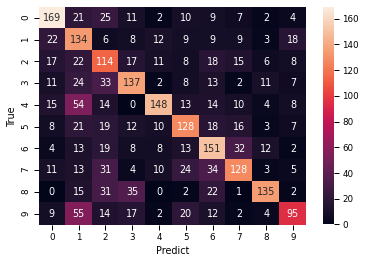

In [69]:
%%time

sns.set_context('paper')
sns.heatmap(confusion_matrix(validation_features.digit.values, predict_nb1), annot=True, fmt='g')
plt.xlabel('Predict')
plt.ylabel('True')

### Impacto del ruido en el rendimiento 

In [66]:
%%time

naive_bayes_dev = GaussianNB()
naive_bayes_dev.fit(develop_features.drop('digit',axis=1).values, develop_features.digit.values)
predict_nb_test = naive_bayes_dev.predict(test_features.drop('digit',axis=1).values)
predict_nb_gauss = naive_bayes_dev.predict(test_features_gauss.drop('digit',axis=1).values)
predict_nb_dishes = naive_bayes_dev.predict(test_features_dishes.drop('digit',axis=1).values)
predict_nb_dude = naive_bayes_dev.predict(test_features_dude.drop('digit',axis=1).values)
predict_nb_bike = naive_bayes_dev.predict(test_features_bike.drop('digit',axis=1).values)
predict_nb_running = naive_bayes_dev.predict(test_features_running.drop('digit',axis=1).values)
predict_nb_pink = naive_bayes_dev.predict(test_features_pink.drop('digit',axis=1).values)
predict_nb_white = naive_bayes_dev.predict(test_features_white.drop('digit',axis=1).values)

printAccuracy("Develop", naive_bayes_dev, develop_features)

printAccuracy("Test", naive_bayes_dev, test_features)
print(classification_report(test_features.digit.values, predict_nb_test))

printAccuracy("Ruido Gaussiano", naive_bayes_dev, test_features_gauss)
print(classification_report(test_features_gauss.digit.values, predict_nb_gauss, zero_division=0))

printAccuracy("Ruido Doing the Dishes", naive_bayes_dev, test_features_dishes)
print(classification_report(test_features_dishes.digit.values, predict_nb_dishes, zero_division=0))

printAccuracy("Ruido Dude Miaowing", naive_bayes_dev, test_features_dude)
print(classification_report(test_features_dude.digit.values, predict_nb_dude, zero_division=0))

printAccuracy("Ruido Exercise Bike", naive_bayes_dev, test_features_bike)
print(classification_report(test_features_bike.digit.values, predict_nb_bike, zero_division=0))

printAccuracy("Ruido Running Tap", naive_bayes_dev, test_features_running)
print(classification_report(test_features_running.digit.values, predict_nb_running, zero_division=0))

printAccuracy("Ruido Pink Noise", naive_bayes_dev, test_features_pink)
print(classification_report(test_features_pink.digit.values, predict_nb_pink, zero_division=0))

printAccuracy("Ruido White Noise", naive_bayes_dev, test_features_white)
print(classification_report(test_features_white.digit.values, predict_nb_white, zero_division=0))



Accuracy Develop : 0.542
Accuracy Test : 0.531
              precision    recall  f1-score   support

           0       0.55      0.50      0.52       250
           1       0.41      0.49      0.45       248
           2       0.41      0.50      0.45       264
           3       0.54      0.48      0.51       267
           4       0.71      0.57      0.63       253
           5       0.57      0.59      0.58       271
           6       0.48      0.65      0.55       244
           7       0.56      0.46      0.51       239
           8       0.62      0.61      0.61       257
           9       0.59      0.45      0.51       259

    accuracy                           0.53      2552
   macro avg       0.54      0.53      0.53      2552
weighted avg       0.54      0.53      0.53      2552

Accuracy Ruido Gaussiano : 0.098
              precision    recall  f1-score   support

           0       0.10      1.00      0.18       250
           1       0.00      0.00      0.00       24

## Random Forest:  búsqueda de hiperparámetros óptimos

In [68]:
%%time

parametros = {'n_estimators':range(100, 250, 15), 'max_depth':range(6, 12, 2), 'bootstrap':[True, False]}

clf = RandomizedSearchCV(RandomForestClassifier(random_state=22), parametros, n_jobs=20, random_state=131313,    
                         scoring='accuracy', n_iter=30, cv =  [(slice(None), slice(None))])

clf.fit(train_features.drop('digit',axis=1).values, train_features.digit.values)
rf = clf.best_estimator_  

print(clf.best_score_, clf.best_params_)
printAccuracy("Training", rf, train_features)
printAccuracy("Validation", rf, validation_features)

0.8948979591836734 {'n_estimators': 220, 'max_depth': 10, 'bootstrap': False}
Accuracy Training : 0.895
Accuracy Validation : 0.664
CPU times: user 33.3 s, sys: 52 ms, total: 33.3 s
Wall time: 3min 7s


###  Matriz de Confusión 

Text(32.7, 0.5, 'True')

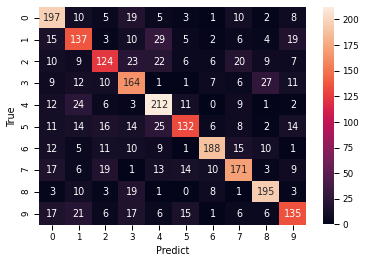

In [70]:
rf_pred = rf.predict(validation_features.drop('digit',axis=1).values)
sns.set_context('paper')
sns.heatmap(confusion_matrix(validation_features.digit.values, rf_pred), annot=True, fmt='g')
plt.xlabel('Predict')
plt.ylabel('True')

### Impacto del ruido en el rendimiento 

In [71]:
%%time

rf.fit(develop_features.drop('digit',axis=1).values, develop_features.digit.values)
printAccuracy("Develop", rf, develop_features)
printAccuracy("Test", rf, test_features)
printAccuracy("Ruido Gaussiano", rf, test_features_gauss)
printAccuracy("Ruido Doing the Dishes", rf, test_features_dishes)
printAccuracy("Ruido Dude Miaowing", rf, test_features_dude)
printAccuracy("Ruido Exercise Bike", rf, test_features_bike)
printAccuracy("Ruido Running Tap", rf, test_features_running)
printAccuracy("Ruido Pink Noise", rf, test_features_pink)
printAccuracy("Ruido White Noise", rf, test_features_white)

Accuracy Develop : 0.879
Accuracy Test : 0.644
Accuracy Ruido Gaussiano : 0.098
Accuracy Ruido Doing the Dishes : 0.325
Accuracy Ruido Dude Miaowing : 0.621
Accuracy Ruido Exercise Bike : 0.365
Accuracy Ruido Running Tap : 0.207
Accuracy Ruido Pink Noise : 0.116
Accuracy Ruido White Noise : 0.101
CPU times: user 35.8 s, sys: 0 ns, total: 35.8 s
Wall time: 35.8 s


## Gradient Boosting

In [73]:
%%time

parameters = {'n_estimators':range(50, 150, 25), 'max_depth':range(5,7), 'learning_rate':np.arange(0,1,0.1)}
clf = RandomizedSearchCV(GradientBoostingClassifier(random_state=22), parameters, n_jobs=-1, scoring='accuracy',cv=[(slice(None), slice(None))], n_iter=50, random_state=8)

clf.fit(train_features.drop('digit',axis=1).values, train_features.digit.values)
gb = clf.best_estimator_

print (clf.best_score_, clf.best_params_)
printAccuracy("Training", gb, train_features)
printAccuracy("Validation", gb, validation_features)

1.0 {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.2}
Accuracy Training : 1.000
Accuracy Validation : 0.741
CPU times: user 17min 7s, sys: 0 ns, total: 17min 7s
Wall time: 2h 48min 32s


###  Matriz de Confusión 

Text(32.7, 0.5, 'True')

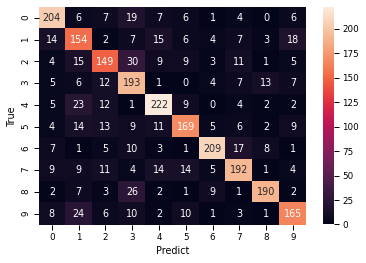

In [74]:
gb_pred = gb.predict(validation_features.drop('digit',axis=1).values)
sns.set_context('paper')
sns.heatmap(confusion_matrix(validation_features.digit.values, gb_pred), annot=True, fmt='g')
plt.xlabel('Predict')
plt.ylabel('True')

### Impacto del ruido en el rendimiento 

In [75]:
%%time

gb.fit(develop_features.drop('digit',axis=1).values, develop_features.digit.values)
printAccuracy("Develop", gb, develop_features)
printAccuracy("Test", gb, test_features)
printAccuracy("Ruido Gaussiano", gb, test_features_gauss)
printAccuracy("Ruido Doing the Dishes", gb, test_features_dishes)
printAccuracy("Ruido Dude Miaowing", gb, test_features_dude)
printAccuracy("Ruido Exercise Bike", gb, test_features_bike)
printAccuracy("Ruido Running Tap", gb, test_features_running)
printAccuracy("Ruido Pink Noise", gb, test_features_pink)
printAccuracy("Ruido White Noise", gb, test_features_white)

Accuracy Develop : 1.000
Accuracy Test : 0.745
Accuracy Ruido Gaussiano : 0.102
Accuracy Ruido Doing the Dishes : 0.414
Accuracy Ruido Dude Miaowing : 0.688
Accuracy Ruido Exercise Bike : 0.457
Accuracy Ruido Running Tap : 0.313
Accuracy Ruido Pink Noise : 0.125
Accuracy Ruido White Noise : 0.120
CPU times: user 20min 15s, sys: 0 ns, total: 20min 15s
Wall time: 20min 18s


# Anexos

## Tratamiento audio grabados por el equipo

In [76]:
audios_nos = []
# x es un array de numpy numpy.ndarray, fs un entero int
x, fs = librosa.core.load('audios/s_normal.wav', sr = 16000)
audios_nos += [x]
audios_nos

[array([ 0.        ,  0.        ,  0.        , ..., -0.00268988,
        -0.00342985,  0.        ], dtype=float32)]

In [77]:
import os

# nparray, fs, filename sin extension
audios_nos = []

# guarda el array de np de todos los audios
for filename in os.listdir("audios"):
    if filename.endswith(".wav"):
        x, fs = librosa.core.load('audios/' + filename, sr = 16000)
        # saca la extension y separa luego el autor de la condicion
        audios_nos += [[x] + [fs] + filename.split('.')]
        #display(Audio(x, rate = fs))
        #plt.figure(figsize = (15,5))
        #plt.plot(x)

, 's_exterior':24
i: 7


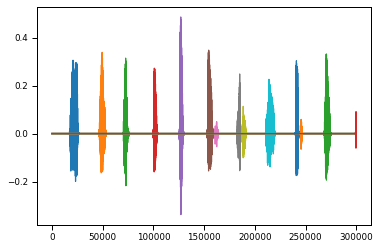

In [78]:
# a mano cada audio pra verificar que se separen bien
# splits {'dc_baño1':25, 'dc_baño2':25, 'dc_calle':28, 'dc_cocinando':27, 'dc_normal':27,
#          'dh_agua':20, 'dh_baño':15,

# este metodo de separar los audios se hace engorroso pues cambiando top_db se empieza a perder info del audio
# es compromiso entre que separe ruidos y que se entiendan los numeros... y a veces no se logra 
i = 7
top_db = 24

x = audios_nos[i][0]

print(", \'",audios_nos[i][2], "\'", ":", top_db, "\n", "i: ", i, sep = "")

split_points = librosa.effects.split(x, top_db = top_db)
for split in split_points:
    xplot = np.zeros_like(x)
    xplot[split[0]:split[1]] = x[split[0]:split[1]]
    plt.plot(xplot)
    display(Audio(x[split[0]:split[1]], rate = fs))
